In [16]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [17]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.volume import *
from tomopt.core import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [18]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*9999999
    if z >= 0.4 and z <= 0.5:
        rad_length[:5,:5] = X0['beryllium']
        rad_length[5:,5:] = X0['lead']
    return rad_length

In [19]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [20]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [21]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 10000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [22]:
from tomopt.optimisation import *
from functools import partial

In [23]:
volume = Volume(get_layers())

In [9]:
wrapper = VolumeWrapper(volume=volume, res_opt=partial(torch.optim.SGD, lr=2e1), eff_opt=partial(torch.optim.SGD, lr=2e-5), loss_func=DetectorLoss(0.15))

In [10]:
trn_passives = PassiveYielder([arb_rad_length])

In [11]:
preds = wrapper.predict(trn_passives, n_mu_per_volume=10000, mu_bs=100)

In [12]:
X0['lead'],X0['beryllium']

(0.005612, 0.3528)

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

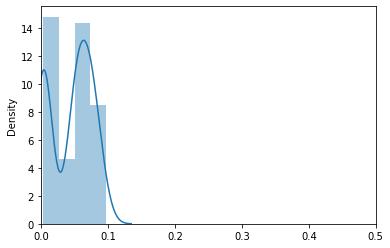

In [13]:
p = preds[0][0][2].flatten()
sns.distplot(p)
plt.xlim(0,0.5)

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

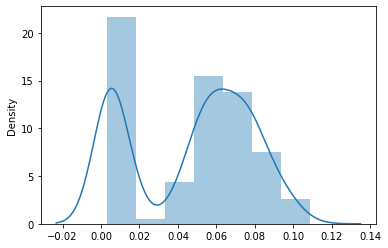

In [14]:
p = preds[0][0].flatten()
sns.distplot(p)

In [24]:
mu = MuonBatch(generate_batch(100), init_z=1)
volume(mu)
scatters = ScatterBatch(mu, volume)
inferer = X0Inferer(scatters)

In [25]:
preds, uncs = inferer.x0_from_dtheta()

In [26]:
preds

tensor([8.0648e-02, 3.0640e-01, 2.5946e-02, 7.6874e-03, 9.4116e-02, 1.9404e-01,
        4.7551e-03, 8.5744e-03, 1.1656e-01, 4.6164e-01, 3.5729e-02, 1.3613e-01,
        1.0008e-01, 9.6505e-02, 3.3923e-01, 4.8100e-03, 1.2280e-01, 2.0822e-01,
        2.7203e-02, 1.0167e-03, 9.3950e-02, 1.1965e-01, 2.8940e-02, 9.5273e-02,
        7.5022e-02, 9.9886e-02, 6.0961e-02, 4.4116e-03, 2.8613e-02, 9.9866e-02,
        3.9627e-03, 9.0307e-02, 8.8200e-02, 2.1891e-01, 3.9920e-01, 3.3139e-01,
        8.7287e-02, 1.7295e-01, 1.2549e+00, 6.0269e-02, 2.4675e-01, 3.4449e-01,
        4.2960e-02, 2.3803e-01, 9.5203e-01, 2.6386e-01, 2.0827e-01, 9.9112e-03,
        7.4811e-02, 6.6982e-03, 6.2599e-03, 1.5280e-01, 3.3688e-01, 2.0962e-01],
       grad_fn=<MulBackward0>)

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

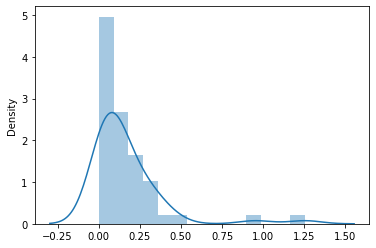

In [27]:
sns.distplot(preds.detach().numpy())

In [28]:
import pandas as pd

In [31]:
df = pd.DataFrame({'X0':preds.detach().numpy(), 'Unc':uncs.detach().numpy()})
df['frac_unc'] = df.Unc/df.X0

In [32]:
df

,X0,Unc,frac_unc
0,0.080648,0.102752,1.274078
1,0.306399,0.581078,1.896472
2,0.025946,0.010503,0.404816
3,0.007687,0.001106,0.143857
4,0.094116,0.088432,0.939602
5,0.194038,0.336001,1.731626
6,0.004755,0.001020,0.214569
7,0.008574,0.002126,0.247934
8,0.116561,0.152743,1.310411
9,0.461640,0.684353,1.482439
